In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import sys
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/nutria
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/sea_lions
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/bald_eagle
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/red_fox
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/raven
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/black_bear
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/cougar
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/deer
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/raccoon
/content/drive/My Drive/Colab Notebooks/oregon_wildlife/oregon_wildlife/virginia_opossum

total img num: 7171


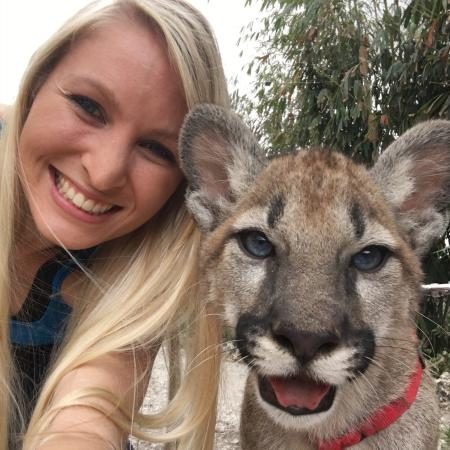

cougar


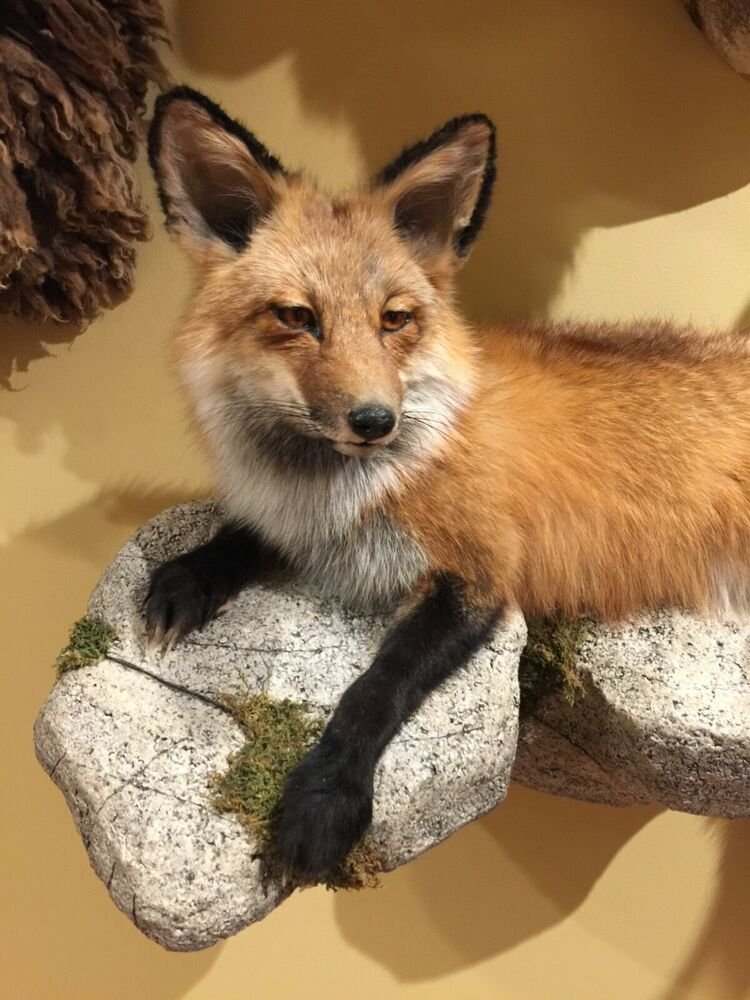

red_fox


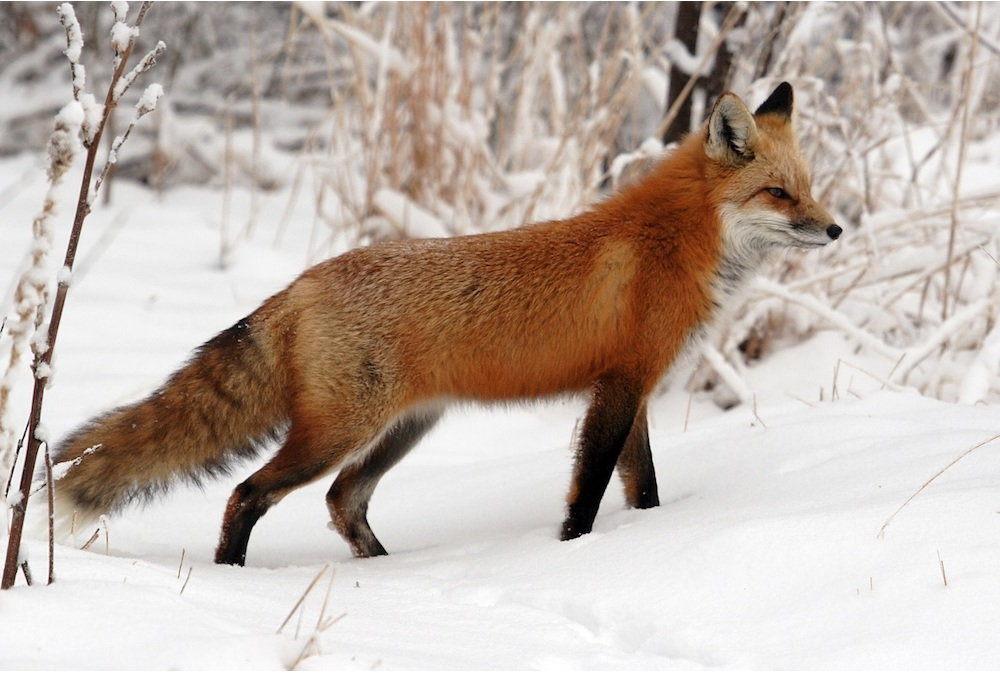

red_fox


In [ ]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [ ]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [ ]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [ ]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 1, 4, 0, 4, 5, 0, 1, 2, 7]


In [ ]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5736
testing data: 1435


In [ ]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [ ]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255.0)
    img = tf.io.serialize_tensor(img)
    return img, label


In [ ]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
print(dataset_train)
dataset_train = dataset_train.map(load_image)
print(dataset_train)
dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>
<MapDataset shapes: ((), ()), types: (tf.string, tf.int32)>


# Todo 1 : write the dataset above to tfrecord

In [ ]:
TRAIN_LEN = len(label_train)
VAL_LEN = len(label_val)
print(TRAIN_LEN)
print(VAL_LEN)

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(feature0, feature1):
    """
    Creates a tf.Example message ready to be written to a file.
    """

    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'feature0-1': _bytes_feature(feature0),
        'feature1': _int64_feature(feature1),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def tf_serialize_example(f0,f1):
    tf_string = tf.py_function(
        serialize_example,
        (f0,f1),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.

    return tf.reshape(tf_string, ()) # The result is a scalar




5736
1435


In [ ]:
serialized_train_dataset = dataset_train.map(tf_serialize_example)
serialized_train_dataset

serialized_val_dataset = dataset_val.map(tf_serialize_example)
serialized_val_dataset

<MapDataset shapes: (), types: tf.string>

In [ ]:
def generator_train():
  for features in dataset_train:
    yield serialize_example(*features)

def generator_val():
  for features in dataset_val:
    yield serialize_example(*features)

serialized_val_dataset = tf.data.Dataset.from_generator(
    generator_val, output_types=tf.string, output_shapes=())

serialized_train_dataset = tf.data.Dataset.from_generator(
    generator_train, output_types=tf.string, output_shapes=())

serialized_train_dataset
serialized_val_dataset


<FlatMapDataset shapes: (), types: tf.string>

In [ ]:
# filename = '/content/drive/My Drive/Colab Notebooks/val_test.tfrecord'
# tf.data.experimental.save(serialized_val_dataset, filename)


In [ ]:
filename_val = '/content/drive/My Drive/Colab Notebooks/lab12/val.tfrecord'
writer_val = tf.data.experimental.TFRecordWriter(filename_val)
writer_val.write(serialized_val_dataset)

In [ ]:
filename_train = '/content/drive/My Drive/Colab Notebooks/lab12/train.tfrecord'
writer_train = tf.data.experimental.TFRecordWriter(filename_train)
writer_train.write(serialized_train_dataset)

# Todo 2 : read the data from tfrecord

In [ ]:
filenames_val = ['/content/drive/My Drive/Colab Notebooks/lab12/val.tfrecord']
raw_dataset_val = tf.data.TFRecordDataset(filenames_val)
raw_dataset_val

filenames_train = ['/content/drive/My Drive/Colab Notebooks/lab12/train.tfrecord']
raw_dataset_train = tf.data.TFRecordDataset(filenames_train)
raw_dataset_train

# Create a description of the features.
feature_description = {
    'feature0-1': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  parsed = tf.io.parse_single_example(example_proto, feature_description)
  return parsed['feature0-1'], parsed['feature1']
#   return parsed

parsed_dataset_val = raw_dataset_val.map(_parse_function)
parsed_dataset_val

parsed_dataset_train = raw_dataset_train.map(_parse_function)
parsed_dataset_train


<MapDataset shapes: ((), ()), types: (tf.string, tf.int64)>

# Todo 3 : preprocess the data

In [ ]:
def my_random_crop(value, size):
    shape = tf.shape(value)
    size = tf.convert_to_tensor(size, dtype = tf.int32)
    limit = shape - size + 1
    offset = tf.random.uniform(tf.shape(shape), dtype = size.dtype, maxval = size.dtype.max) % limit
    return tf.slice(value, offset, size)

def map_fun(image,label):
    image_parse = tf.io.parse_tensor(image, tf.float32)
    image_parse = tf.reshape(image_parse,[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH])
    image_parse = tf.divide(tf.cast(image_parse,tf.float32),255.0)
    label = tf.one_hot(label,11)
    label = tf.cast(label, tf.int64)
    # distorted_image = my_random_crop(image_parse, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_crop(image_parse, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])

    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(
        distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    return distorted_image, label

def map_fun_test(image,label):

    image_parse = tf.io.parse_tensor(image, tf.float32)
    image_parse = tf.reshape(image_parse,[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH])
    image_parse = tf.divide(tf.cast(image_parse,tf.float32),255.0)
    # image_parse = tf.divide(tf.cast(tf.transpose(image_parse,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,11)
    label = tf.cast(label, tf.int64)
    # distorted_image = my_random_crop(image_parse, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_crop(image_parse, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.per_image_standardization(distorted_image)

    return distorted_image, label

parsed_dataset_val = parsed_dataset_val.map(map_fun_test)
parsed_dataset_train = parsed_dataset_train.map(map_fun)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


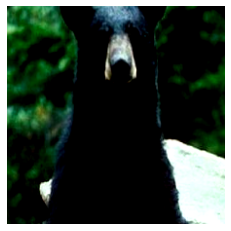

In [ ]:
for img, label in parsed_dataset_train.take(1):
    print(img.shape)
    plt.imshow(img) 
    plt.axis('off') 
    plt.show()
    # print(index_to_label[label[0].numpy()])

In [ ]:
parsed_dataset_train = parsed_dataset_train.shuffle(BUFFER_SIZE)
parsed_dataset_val = parsed_dataset_val.shuffle(BUFFER_SIZE)

parsed_dataset_train = parsed_dataset_train.batch(BATCH_SIZE)
parsed_dataset_val = parsed_dataset_val.batch(BATCH_SIZE)

parsed_dataset_train = parsed_dataset_train.repeat(2)
parsed_dataset_val = parsed_dataset_val.repeat(2)

In [ ]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(11, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
wild_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
wild_model.fit(parsed_dataset_train, validation_data=parsed_dataset_val, epochs=5)

Epoch 1/5
90/90 [==============================] - 385s 4s/step - loss: 3.5322 - accuracy: 0.3604 - val_loss: 0.7248 - val_accuracy: 0.7829
Epoch 2/5
90/90 [==============================] - 348s 4s/step - loss: 0.9508 - accuracy: 0.6701 - val_loss: 0.5113 - val_accuracy: 0.8453
Epoch 3/5
90/90 [==============================] - 383s 4s/step - loss: 0.8114 - accuracy: 0.7231 - val_loss: 0.4087 - val_accuracy: 0.8690
Epoch 4/5
90/90 [==============================] - 389s 4s/step - loss: 0.7044 - accuracy: 0.7635 - val_loss: 0.3808 - val_accuracy: 0.8801
Epoch 5/5
90/90 [==============================] - 382s 4s/step - loss: 0.6898 - accuracy: 0.7671 - val_loss: 0.3746 - val_accuracy: 0.8930
